# Test Resnet152

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
import os
from keras import layers, models, losses, optimizers, metrics
from random import shuffle
import sys

sys.path.append('../../')

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [8]:
# Construction du dataset

image_size = (224, 224)
batch_size = 16
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "../data/base",
    validation_split=0.2,
    subset="both",
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
    color_mode="rgb"
)

class_names = train_ds.class_names
print("Classes détectées :", class_names)

Found 2093 files belonging to 13 classes.
Using 1675 files for training.
Using 418 files for validation.
Classes détectées : ['castor', 'chat', 'chien', 'coyotte', 'ecureuil', 'lapin', 'loup', 'lynx', 'ours', 'puma', 'rat', 'raton_laveur', 'renard']


tf.Tensor([ 2  3 11  0  4  5  7 10  4  3 11  1  6  3  3  5], shape=(16,), dtype=int32)


2025-06-25 22:33:37.159438: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


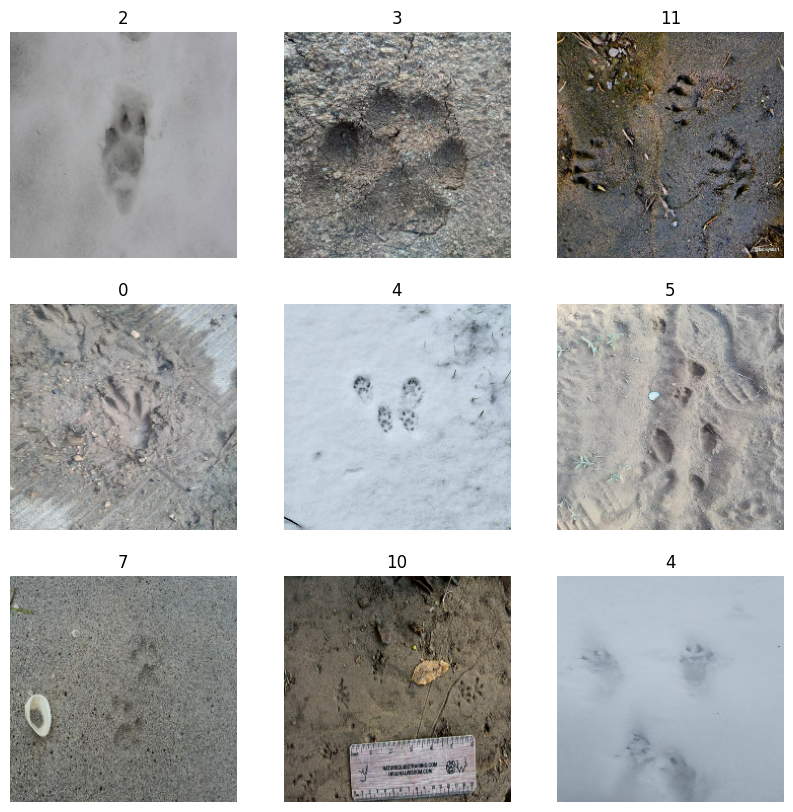

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    print(labels)
    for i in range(min(9, batch_size)):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [10]:
# Couches de prétraitement et modèle de base

data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.2),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomContrast(0.2),
    layers.RandomZoom(0.1),
])

base_model = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet', classifier_activation='softmax')

# for layer in base_model.layers[:100]:
#    layer.trainable = False

model = tf.keras.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='leaky_relu'),
    layers.BatchNormalization(),
    layers.Dense(256, activation='leaky_relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='leaky_relu'),
    layers.BatchNormalization(),
    layers.Dense(len(class_names), activation='softmax')
])

model.build((None, 224, 224, 3))

In [11]:
# Compilation du modèle

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,806,285 (94.63 MB)

 Trainable params: 24,751,373 (94.42 MB)

 Non-trainable params: 54,912 (214.50 KB)

In [12]:
# Entraînement du modèle

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    batch_size=16,
)

Epoch 1/40
105/105 ━━━━━━━━━━━━━━━━━━━━ 24s 84ms/step - accuracy: 0.1287 - loss: 3.0275 - val_accuracy: 0.1603 - val_loss: 2.7880
Epoch 2/40
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.2418 - loss: 2.3291 - val_accuracy: 0.1914 - val_loss: 2.7903
Epoch 3/40
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.3375 - loss: 2.0345 - val_accuracy: 0.2512 - val_loss: 2.7097
Epoch 4/40
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.3685 - loss: 1.9382 - val_accuracy: 0.2249 - val_loss: 2.9082
Epoch 5/40
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.4625 - loss: 1.7451 - val_accuracy: 0.2464 - val_loss: 2.8898
Epoch 6/40
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.4879 - loss: 1.5969 - val_accuracy: 0.2584 - val_loss: 3.0360
Epoch 7/40
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.5387 - loss: 1.4411 - val_accuracy: 0.2344 - val_loss: 2.7010
Epoch 8/40
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.5586 - loss: 1.3548 - val_acc

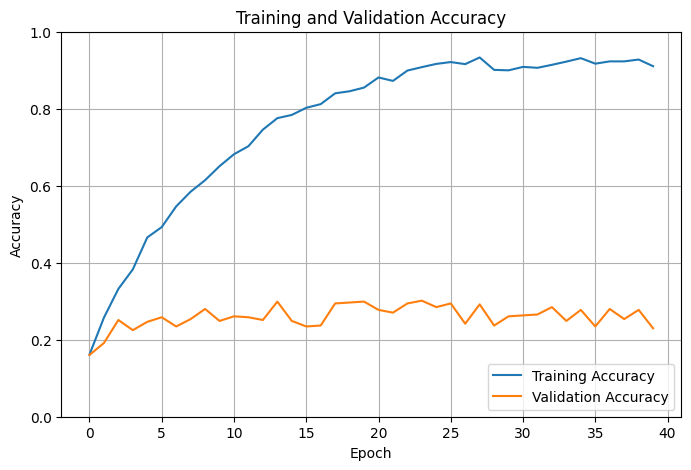

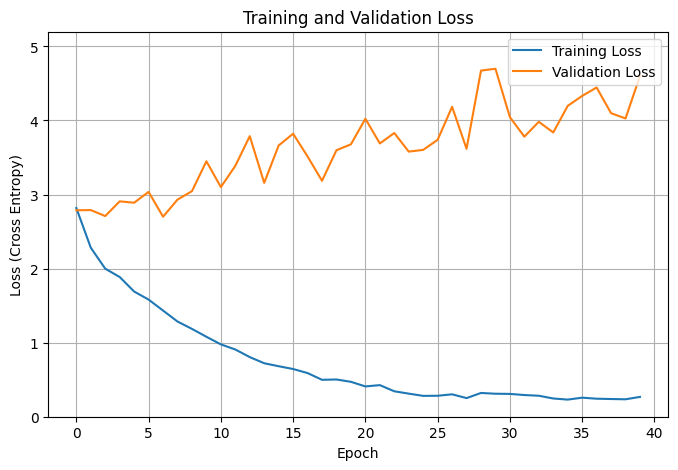

In [13]:
import matplotlib.pyplot as plt

metric_name = "accuracy" 

# === Courbe de précision ===
plt.figure(figsize=(8, 5))
plt.plot(history.history[metric_name], label='Training Accuracy')
plt.plot(history.history[f"val_{metric_name}"], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.grid(True)
plt.show()

# === Courbe de perte ===
plt.figure(figsize=(8, 5))
plt.plot(history.history["loss"], label='Training Loss')
plt.plot(history.history["val_loss"], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Cross Entropy)')
plt.ylim([0, max(max(history.history["loss"]), max(history.history["val_loss"])) + 0.5])
plt.grid(True)
plt.show()


In [14]:
castor = tf.io.read_file("/home/shared/Mammiferes_jpg/Castor/original.jpeg")
castor = tf.image.decode_jpeg(castor, channels=3)
resized_castor = tf.image.resize(castor, [256,256], method="bilinear")

input = tf.expand_dims(
    resized_castor,
    axis = 0
)

footprint_model.predict(input)

2025-06-25 22:39:05.869565: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: /home/shared/Mammiferes_jpg/Castor/original.jpeg; No such file or directory


NotFoundError: {{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} /home/shared/Mammiferes_jpg/Castor/original.jpeg; No such file or directory [Op:ReadFile]